In [1]:
using PyPlot
using JLD2

include("../src/linear_merging.jl")

BLAS.set_num_threads(1)

In [2]:
function exactdp(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_dp(X, y, k)
end

function merging_k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, k, floor(Int, k / 2.0), initial_merging_size=d)
end

function merging_2k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, 2 * k, k, initial_merging_size=d)
end

function merging_4k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, 4 * k, 2 * k, initial_merging_size=d)
end

algos = Dict([("exactdp", exactdp), ("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])

Dict{String, Function} with 4 entries:
  "exactdp"    => exactdp
  "merging_2k" => merging_2k
  "merging_4k" => merging_4k
  "merging_k"  => merging_k

In [3]:
num_data_sets = 1
num_trials = 10
sigma = 1.0
n_vals = round.(Int, 10 .^ range(2.0, stop=4.0, length=7))
k = 5
d = 10
mses = Dict{String, Array{Float64, 2}}()
times = Dict{String, Array{Float64, 2}}()

for algo_name in keys(algos)
    mses[algo_name] = Array{Float64}(undef, length(n_vals), num_trials * num_data_sets)
    times[algo_name] = Array{Float64}(undef, length(n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 100
y, ystar, X = generate_equal_size_random_regression_data(k, n_warmup, d, sigma);
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in algos
    yhat_partition = algo_fun(X, y, k)
end

for (nii, n) in enumerate(n_vals)
    @printf("n = %d  ", n)
    
    @time begin
    for iidata = 1:num_data_sets
        @printf("*")
        
        for ii = 1:num_trials
            @printf(".")
            #@printf("  trial %d\n", ii)
            y, ystar, X = generate_equal_size_random_regression_data(k, n, d, sigma);

            for (algo_name, algo_fun) in algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(X, y, k)
                end_time = time_ns()
                yhat = partition_to_vector(X, yhat_partition)
                mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    end
end
mses_mean = Dict{AbstractString, Array{Float64, 1}}()
mses_std = Dict{AbstractString, Array{Float64, 1}}()
times_mean = Dict{AbstractString, Array{Float64, 1}}()
times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(mses)
    mses_mean[algo_name] = vec(mean(mses[algo_name], dims=2))
    mses_std[algo_name] = vec(std(mses[algo_name], dims=2))
    times_mean[algo_name] = vec(mean(times[algo_name], dims=2))
    times_std[algo_name] = vec(std(times[algo_name], dims=2))
end

Warm-up with n = 100
n = 100  *..........  0.401292 seconds (1.30 M allocations: 936.505 MiB, 46.34% gc time, 21.89% compilation time)
n = 215  *..........  0.551488 seconds (4.30 M allocations: 2.758 GiB, 17.76% gc time)
n = 464  *..........  2.028583 seconds (17.99 M allocations: 9.609 GiB, 18.48% gc time)
n = 1000  *..........  8.547901 seconds (78.97 M allocations: 37.474 GiB, 15.22% gc time)
n = 2154  *.......... 36.458635 seconds (356.52 M allocations: 158.349 GiB, 12.77% gc time)
n = 4642  *..........207.626944 seconds (1.63 G allocations: 701.832 GiB, 23.44% gc time)
n = 10000  *..........1142.930474 seconds (7.54 G allocations: 3.110 TiB, 30.94% gc time)


In [4]:
algo_colors = Dict([("exactdp", "blue"), ("merging_2k", "green"), ("merging_4k", "red"), ("merging_k", "olive")])

Dict{String, String} with 4 entries:
  "exactdp"    => "blue"
  "merging_2k" => "green"
  "merging_4k" => "red"
  "merging_k"  => "olive"

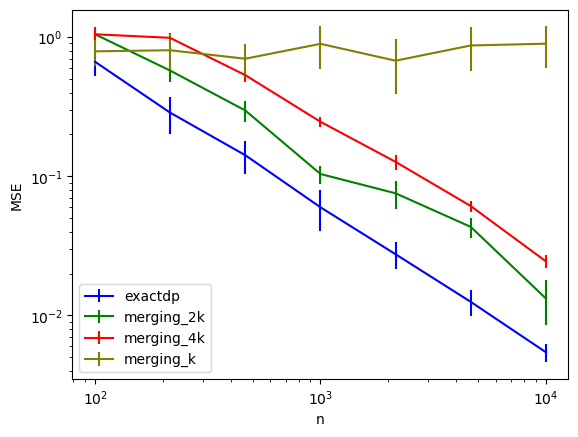

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [5]:
for (algo_name, algo_mses) in mses_mean
    errorbar(n_vals, algo_mses, yerr=mses_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
#plot(n_vals, 200.0 ./ n_vals, label="C/n")
#plot(n_vals, 5.0 ./ sqrt(n_vals), label="C/sqrt(n)", color="olive")
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("MSE")

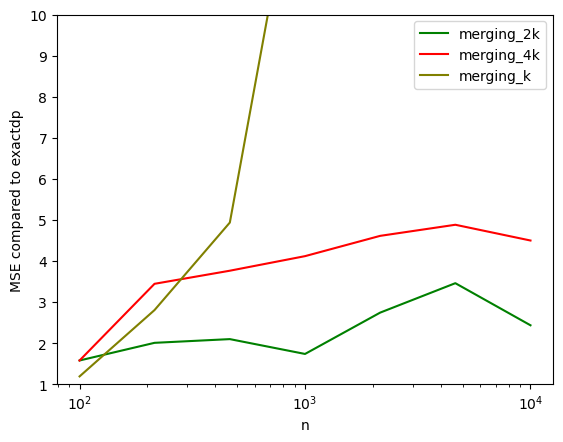

(1.0, 10.0)

In [6]:
exactdp_mses = mses_mean["exactdp"]
for (algo_name, algo_mses) in mses_mean
    if algo_name != "exactdp"
        plot(n_vals, algo_mses ./ exactdp_mses, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
xscale("log")
xlabel("n")
ylabel("MSE compared to exactdp")
ylim([1, 10])

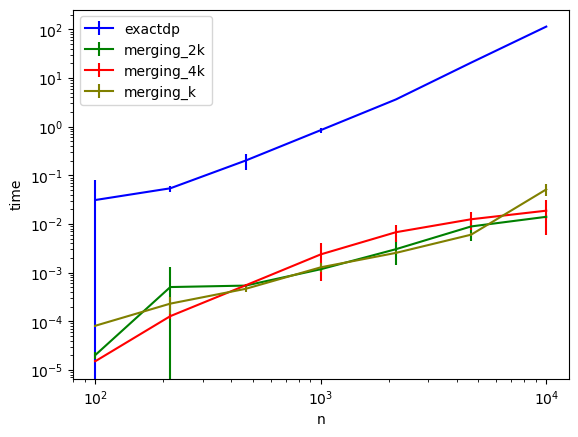

PyObject Text(24.000000000000007, 0.5, 'time')

In [7]:
for (algo_name, algo_times) in times_mean
    errorbar(n_vals, algo_times, yerr=times_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("time")

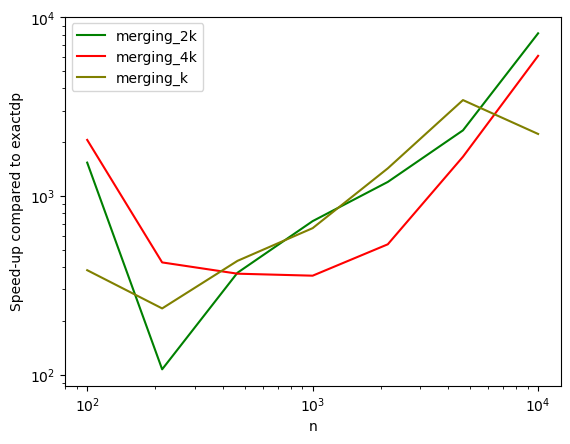

PyObject Text(24.00000000000002, 0.5, 'Speed-up compared to exactdp')

In [8]:
exactdp_times = times_mean["exactdp"]
for (algo_name, algo_times) in times_mean
    if algo_name != "exactdp"
        plot(n_vals, exactdp_times ./ algo_times, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("Speed-up compared to exactdp")

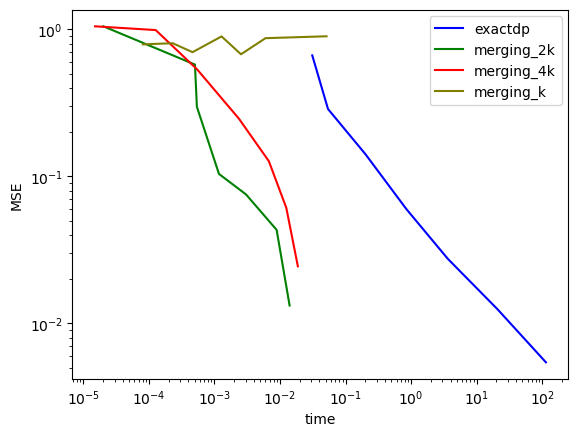

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [9]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [10]:
mses_mean["exactdp"]

7-element Vector{Float64}:
 0.665322943620619
 0.28714604549474515
 0.1417419043399281
 0.05989015346618095
 0.027529047427286672
 0.01252057528547984
 0.005441871204645897

In [11]:
mses_mean["merging_2k"]

7-element Vector{Float64}:
 1.0483948894764583
 0.5758542904175225
 0.2970864688158244
 0.1038895913890397
 0.07546281366894488
 0.0432951887141038
 0.013239069074635504

In [12]:
0.0217 / 0.0059

3.6779661016949152

In [13]:
0.359 / 0.097

3.7010309278350513

In [14]:
n_vals

7-element Vector{Int64}:
   100
   215
   464
  1000
  2154
  4642
 10000

In [15]:
times_mean["exactdp"]

7-element Vector{Float64}:
   0.031071139000000005
   0.054082749500000006
   0.2010365712
   0.8495790980000001
   3.632952679
  20.7342104111
 114.20712401500002

In [16]:
times_mean["merging_2k"]

7-element Vector{Float64}:
 2.01937e-5
 0.0005043671000000002
 0.0005401548999999999
 0.0011736083
 0.0030287315000000004
 0.0088908103
 0.014026614400000002

In [17]:
times_mean["exactdp"][6] / times_mean["merging_2k"][6]

2332.0945686019195

In [18]:
extra_algos = Dict([("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])
extra_n_vals = round.(Int, 10 .^ range(4.0, stop=6.0, length=7))
extra_mses = Dict{String, Array{Float64, 2}}()
extra_times = Dict{String, Array{Float64, 2}}()

for algo_name in keys(extra_algos)
    extra_mses[algo_name] = Array{Float64}(undef, length(extra_n_vals), num_trials * num_data_sets)
    extra_times[algo_name] = Array{Float64}(undef, length(extra_n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
y, ystar, X = generate_equal_size_random_regression_data(k, n_warmup, d, sigma);
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in extra_algos
    yhat_partition = algo_fun(X, y, k)
end

for (nii, n) in enumerate(extra_n_vals)
    @printf("n = %d  ", n)
    
    @time begin
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf("*")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            @printf(".")
            y, ystar, X = generate_equal_size_random_regression_data(k, n, d, sigma);

            for (algo_name, algo_fun) in extra_algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(X, y, k)
                end_time = time_ns()
                yhat = partition_to_vector(X, yhat_partition)
                extra_mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                extra_times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    end
end

extra_mses_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_mses_std = Dict{AbstractString, Array{Float64, 1}}()
extra_times_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(extra_mses)
    extra_mses_mean[algo_name] = vec(mean(extra_mses[algo_name], dims=2))
    extra_mses_std[algo_name] = vec(std(extra_mses[algo_name], dims=2))
    extra_times_mean[algo_name] = vec(mean(extra_times[algo_name], dims=2))
    extra_times_std[algo_name] = vec(std(extra_times[algo_name], dims=2))
end

Warm-up with n = 1000
n = 10000  *..........  0.698525 seconds (2.49 M allocations: 2.032 GiB, 32.61% gc time, 1.45% compilation time)
n = 21544  *..........  1.661980 seconds (5.28 M allocations: 4.593 GiB, 41.28% gc time)
n = 46416  *..........  3.640594 seconds (11.28 M allocations: 10.236 GiB, 42.42% gc time)
n = 100000  *..........  7.536867 seconds (24.19 M allocations: 22.597 GiB, 35.98% gc time)
n = 215443  *.......... 17.021638 seconds (51.99 M allocations: 50.735 GiB, 33.49% gc time)
n = 464159  *.......... 38.046477 seconds (111.87 M allocations: 113.001 GiB, 35.30% gc time)
n = 1000000  *.......... 81.453446 seconds (240.84 M allocations: 253.934 GiB, 34.18% gc time)


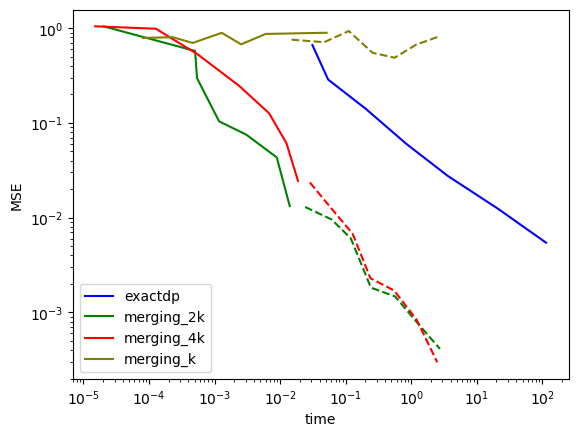

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [19]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
for (algo_name, algo_times) in extra_times_mean
    plot(algo_times, extra_mses_mean[algo_name], color=algo_colors[algo_name], linestyle="--")
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [ ]:
X = zeros(1,1)
ystar = yhat = y = zeros(1)

@save "experiments5_k5.jld2"

In [ ]:
include("../src/helpers.jl")

In [ ]:
for algo_name in keys(algos)
    write_experiment_data_with_ratios("experiments5_k5", algo_name, "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)
end

In [ ]:
for algo_name in keys(extra_algos)
    write_experiment_data("experiments5_k5_extra", algo_name, extra_n_vals, extra_mses_mean, extra_mses_std, extra_times_mean, extra_times_std)
end